# Mount Drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# %cd 'drive/My Drive/CAD PROJECT'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file_id_train = "1TVxWUeHMEoFZKzD9jhzj_9rhnmuX3Akm"
file_id_val = "10ZIucn6vkHf_ZiVFLnDLtdPBuyUK6ww9"

# https://drive.google.com/file/d/1TVxWUeHMEoFZKzD9jhzj_9rhnmuX3Akm/view?usp=sharing
# https://drive.google.com/file/d/10ZIucn6vkHf_ZiVFLnDLtdPBuyUK6ww9/view?usp=sharing

# Downloading script that helps in fetching files from google drive
!git clone https://github.com/chentinghao/download_google_drive.git
%cd download_google_drive

!python download_gdrive.py $file_id_train /content/train.tar.gz
!python download_gdrive.py $file_id_val /content/val.tar.gz

%cd /content/
!tar -xf train.tar.gz
!tar -xf val.tar.gz

Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
/content/download_google_drive
584MB [00:02, 262MB/s]
73.4MB [00:00, 126MB/s]
/content


In [0]:
!ls /content/val/m0 | wc -l

1639


# Import stuff

In [0]:
!pip install barbar
from barbar import Bar

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import logging

# Create Experiment Folder

In [0]:
# -----------------------------
# create a folder for the experiments
# -----------------------------
tmpdir = "drive/My Drive/CAD PROJECT/histo_experiments"
if not (os.path.exists(tmpdir)):
    os.mkdir(tmpdir)

exp_name = "g_exp_vgg19_fn_Aug_Adam4"
tmpdir = os.path.join(tmpdir, exp_name)
if not (os.path.exists(tmpdir)):
    os.mkdir(tmpdir)

# Set the Logger

In [0]:
# -----------------------------
# set the logger
# -----------------------------
logger = logging.getLogger()
fh = logging.FileHandler("{}/{}.log".format(tmpdir, exp_name))
sh = logging.StreamHandler(sys.stdout)
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# fh.setFormatter(formatter)
# sh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(sh)
logger.setLevel(logging.INFO)
logger.info("Logging initiated")

Logging initiated


# Utilities functions

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(options['normalize_mean'])
    std = np.array(options['normalize_std'])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def plotMetrics(training_acc, val_acc, training_loss, val_loss):        
    current_time = time.time()
    # training and val accuracy
    epoch_list = tuple(range(0,len(training_acc),1))
    plt.plot(training_acc)
    plt.plot(val_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("{}/accuracy.png".format(tmpdir))
    plt.show()

    # training and val loss
    plt.plot(training_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("{}/loss.png".format(tmpdir))
    plt.show()

# Configuration options

In [0]:
# TRAIN_PATH = '/content/train'
# VAL_PATH = '/content/val'
data_dir = '/content/'

options = {}

# input image size
# inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224).
# options['input_size'] = (224,224)
target_size = 96
# normalization mean
options['normalize_mean'] = [0.485, 0.456, 0.406]
# normalization mean
options['normalize_std'] = [0.229, 0.224, 0.225]

# options["models"]='/content/drive/My Drive/CAD PROJECT/Results/SKIN_MODELS/'

# Data preparation

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(target_size), 
        # transforms.RandomCrop(options['input_size'], padding=None, pad_if_needed=True),
        transforms.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1)),
        transforms.RandomRotation(degrees=30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomResizedCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(options['normalize_mean'], options['normalize_std']) #calculated_mean, calculated_std for mean 0 and std 1
    ]),
    'val': transforms.Compose([
        # transforms.Resize(target_size), 
        # transforms.CenterCrop(options['input_size']),     
        transforms.ToTensor(),
        transforms.Normalize(options['normalize_mean'], options['normalize_std'])
    ]),
}

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'),data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(class_names)

{'train': 26216, 'val': 3278}
['b0', 'm0']


# Sample Batch

torch.Size([16, 3, 96, 96])
torch.Size([16])


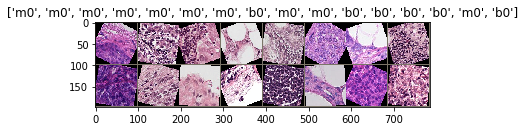

In [0]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Import Model

In [0]:
options["model_type"] = "vgg16"
is_inception = False

if options["model_type"] == "inceptionV3":
  is_inception = True
  histo_model = models.inception_v3(pretrained=True)
  num_in_ftrs1 = histo_model.AuxLogits.fc.in_features
  histo_model.AuxLogits.fc = nn.Linear(num_in_ftrs1, 2)  
  num_in_ftrs = histo_model.fc.in_features
  histo_model.fc = nn.Linear(num_in_ftrs, 2)

  # for param in histo_model.fc.parameters():
  #   param.requires_grad = False

  # for param in histo_model.fc.parameters():
  #     param.requires_grad = True

  # for param in histo_model.AuxLogits.fc.parameters():
  #     param.requires_grad = True

elif options["model_type"] == "resnet":  
  # histo_model = models.resnet152(pretrained=True)
  # histo_model = models.resnet50(pretrained=True)
  histo_model = models.resnet34(pretrained=True)
  num_in_ftrs = histo_model.fc.in_features
  histo_model.fc = nn.Linear(num_in_ftrs, 2)

  # for param in histo_model.parameters():
  #   param.requires_grad = False

  # for param in histo_model.fc.parameters():
  #     param.requires_grad = True  

elif options["model_type"] == "densenet":  
  histo_model = models.densenet161(pretrained=True)
  num_in_ftrs = histo_model.classifier.in_features
  histo_model.classifier = nn.Linear(num_in_ftrs, 2)

  # for param in histo_model.parameters():
  #   param.requires_grad = False

  # for param in histo_model.classifier.parameters():
  #     param.requires_grad = True

elif options["model_type"] == "vgg16":  
  histo_model = models.vgg19_bn(pretrained=True)
  num_in_ftrs = histo_model.classifier[6].in_features
  histo_model.classifier[6] = nn.Linear(num_in_ftrs, 2)

  # for param in histo_model.parameters():
  #     param.requires_grad = False

  # for param in histo_model.classifier[6].parameters():
  #     param.requires_grad = True

elif options["model_type"] == "mobilenetV2":  
  histo_model = models.mobilenet_v2(pretrained=True)
  num_in_ftrs = histo_model.classifier[1].in_features
  histo_model.classifier[1] = nn.Linear(num_in_ftrs, 2)

  # for param in histo_model.parameters():
  #   param.requires_grad = False

  # for param in histo_model.classifier.parameters():
  #     param.requires_grad = True

else:
  print("Please choose the correct model")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:08<00:00, 70.2MB/s]


In [0]:
# histo_model = models.vgg16_bn(pretrained=True)
# num_in_ftrs = histo_model.classifier[6].in_features
# histo_model.classifier[6] = nn.Linear(num_in_ftrs, 2)

# for param in histo_model.parameters():
#     param.requires_grad = False

# for param in histo_model.classifier[6].parameters():
#     param.requires_grad = True

for child_name, child in histo_model.named_children():
    print(child_name)

histo_model = histo_model.to(device)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in histo_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in histo_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

features
avgpool
classifier
139,589,442 total parameters.
139,589,442 training parameters.


In [0]:
# Observe that all parameters are being optimized
options["optim"] = "adam"

if options["optim"] == "sgd":
  optimizer = optim.SGD(histo_model.parameters(), lr=0.001, momentum=0.9)
elif options["optim"] == "adadelta":  
  optimizer = optim.Adadelta(histo_model.parameters())
elif options["optim"] == "adam":  
  optimizer = optim.Adam(histo_model.parameters(), lr=0.001, weight_decay=0.0001) #weight_decay, lambda, L2 regularization
else:
  print("Please choose correct optimizer")

# specify the loss function
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training + Evaluation

Epoch 1/100
----------
26216/26216: [===============================>] - ETA 0.3s
train Loss: 0.7875 Acc: 0.6822
3278/3278: [===============================>] - ETA 0.1s
val Loss: 0.6615 Acc: 0.7404
val loss decreased...saving model

Epoch 2/100
----------
26216/26216: [===============================>] - ETA 0.2s
train Loss: 0.6762 Acc: 0.7255
3278/3278: [===============================>] - ETA 0.1s
val Loss: 0.6430 Acc: 0.7675
val loss decreased...saving model

Epoch 3/100
----------
26216/26216: [===============================>] - ETA 0.2s
train Loss: 0.5619 Acc: 0.7528
3278/3278: [===============================>] - ETA 0.1s
val Loss: 0.6539 Acc: 0.7398

Epoch 4/100
----------
26216/26216: [===============================>] - ETA 0.2s
train Loss: 0.5440 Acc: 0.7634
3278/3278: [===============================>] - ETA 0.1s
val Loss: 0.6003 Acc: 0.6751
val loss decreased...saving model

Epoch 5/100
----------
26216/26216: [===============================>] - ETA 0.2s
train Loss: 0.51

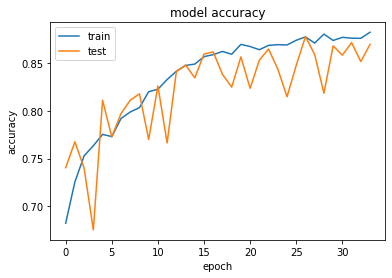

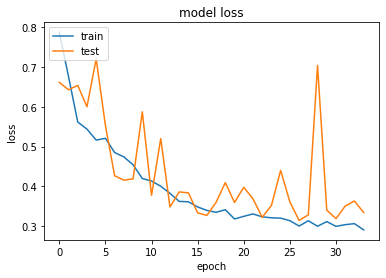

3278/3278: [===============================>] - ETA 0.1s
Validation Confusion Matrix:
tensor([[1483.,  156.],
        [ 244., 1395.]])

Validation Per-class accuracy:
tensor([0.9048, 0.8511])
26216/26216: [===============================>] - ETA 0.1s
Training Confusion Matrix:
tensor([[11915.,  1193.],
        [ 1499., 11609.]])

Training Per-class accuracy:
tensor([0.9090, 0.8856])


In [0]:
num_epochs=100
mytime = time.strftime("%Y_%m_%d_%HH_%MM")
model_name = 'histomodel_'+ mytime
try:
  since = time.time()

  best_model_wts = copy.deepcopy(histo_model.state_dict())  # intialize with the pretrained weights, state_dict -> load_weight
  best_acc = 0.0
  best_loss = 1e+5
  training_loss = []
  training_acc = []
  val_loss = []
  val_acc = []
  epoch_list = []

  # initialize the early_stopping counter
  early_count = 0

  for epoch in range(num_epochs):
      logger.info('Epoch {}/{}'.format(epoch+1, num_epochs))
      logger.info('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          # print(phase)
          # count = 0
          if phase == 'train':              
              histo_model.train()  # Set model to training mode
          else:
              histo_model.eval()   # Set model to evaluate/testing mode -- dropout, batchnorm will behave differently

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for i, (inputs, labels) in enumerate(Bar(dataloaders[phase])):
              # count+=1
              # print(count)
              inputs = inputs.to(device)
              labels = labels.to(device)
              # print("hey1")

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  
                  # Special case for inception because in training it has an auxiliary output
                  if is_inception and phase == 'train':                    
                    outputs, aux_outputs = histo_model(inputs)
                    # print("heyJ")
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                  else:
                    outputs = histo_model(inputs)
                    # print("hey2")
                    loss = criterion(outputs, labels)

                  _, preds = torch.max(outputs, 1) #argmax
                  

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      # print("hey3")
                      optimizer.step()

              # statistics
              #loss.item() returns the average loss in a batch.... loss.item() * inputs.size(0)= total loss in a batch
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / dataset_sizes[phase] # total loss of all images / no of images
          epoch_acc = running_corrects.double() / dataset_sizes[phase] # total no of correctly predicted images / no of images

          # Save the training and val acc + loss
          if phase == 'train':
            training_acc.append(epoch_acc.cpu().numpy())
            training_loss.append(epoch_loss)
            epoch_list.append(epoch+1)
          else:
            val_acc.append(epoch_acc.cpu().numpy())
            val_loss.append(epoch_loss)

          logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model ( Make a copy of the model if the accuracy on the validation set has improved)
          if phase == 'val' and epoch_loss < best_loss:
              best_loss = epoch_loss
              best_acc = epoch_acc
              logger.info("val loss decreased...saving model")
              best_model_wts = copy.deepcopy(histo_model.state_dict()) #copy its weights
              torch.save(histo_model.state_dict(),'{}/{}_model.pt'.format(tmpdir,exp_name))  
              early_count = 0
          elif phase == 'val' and epoch_loss > best_loss:
              early_count += 1

      logger.info("")
      
      if early_count == 7:
        print("Early stopping")
        break

  time_elapsed = time.time() - since
  logger.info('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  logger.info('Best val Acc: {:4f}'.format(best_acc))

  train_metrics = {'epoch #': epoch_list, 'train_loss': training_loss, 'train_acc': training_acc, 'val_loss': val_loss, 'val_acc': val_acc}
  tr_df = pd.DataFrame(train_metrics, columns=['epoch #', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
  tr_df_csv_path = "{}/training_acc_loss.csv".format(tmpdir)
  tr_df.to_csv(tr_df_csv_path)
  # load best model weights
  histo_model.load_state_dict(best_model_wts)
 
except KeyboardInterrupt:
    pass

#############################################

plotMetrics(training_acc, val_acc, training_loss, val_loss)

#############################################

if False:
  options['gpu_use'] = True
  device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
  histo_model = models.vgg16_bn(pretrained=True)
  num_in_ftrs = histo_model.classifier[6].in_features
  histo_model.classifier[6] = nn.Linear(num_in_ftrs, 2)

  histo_model = histo_model.to(device)  
  histo_model.load_state_dict(torch.load('{}/{}_model.pt'.format(tmpdir,exp_name)))
  
histo_model.eval()
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(Bar(dataloaders['val'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = histo_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

print("Validation Confusion Matrix:")
print(confusion_matrix)
print("\nValidation Per-class accuracy:")
print(per_class_acc)

accuracy = [(per_class_acc[0] + per_class_acc[1]).cpu().numpy() / 2, 0]
sensitivity = [(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])).cpu().numpy(), 0]
specificity = [(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[1,0])).cpu().numpy(), 0]

confusion_matrix = confusion_matrix.cpu().numpy()
per_class_acc = per_class_acc.cpu().numpy()
pred_class = ['pred_negative(b)', 'pred_positive(m)']
conf_dict = {"Predected\actuall": pred_class, "actual_negative(b)": confusion_matrix[:,0], "actuall_positive(m)": confusion_matrix[:,1], "per_class_acc": per_class_acc
             ,"overall_acc": accuracy, "sensitivity": sensitivity, "specificity": specificity }
val_df = pd.DataFrame(conf_dict, columns=['Predected\actuall', 'actual_negative(b)', 'actuall_positive(m)', 'per_class_acc', 'overall_acc', 'sensitivity', 'specificity'])
val_df_csv_path = "{}/Validation_acc_confusionMatrix.csv".format(tmpdir)
val_df.to_csv(val_df_csv_path)

#######################################################

if False:
  options['gpu_use'] = True
  device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
  histo_model = models.vgg16_bn(pretrained=True)
  num_in_ftrs = histo_model.classifier[6].in_features
  histo_model.classifier[6] = nn.Linear(num_in_ftrs, 2)

  histo_model = histo_model.to(device)  
  histo_model.load_state_dict(torch.load('{}/{}_model.pt'.format(tmpdir,exp_name)))
  
histo_model.eval()
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(Bar(dataloaders['train'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = histo_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

print("Training Confusion Matrix:")
print(confusion_matrix)
print("\nTraining Per-class accuracy:")
print(per_class_acc)

accuracy = [(per_class_acc[0] + per_class_acc[1]).cpu().numpy() / 2, 0]
sensitivity = [(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])).cpu().numpy(), 0]
specificity = [(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[1,0])).cpu().numpy(), 0]

confusion_matrix = confusion_matrix.cpu().numpy()
per_class_acc = per_class_acc.cpu().numpy()
pred_class = ['pred_negative(b)', 'pred_positive(m)']
conf_dict = {"Predected\actuall": pred_class, "actual_negative(b)": confusion_matrix[:,0], "actuall_positive(m)": confusion_matrix[:,1], "per_class_acc": per_class_acc
             ,"overall_acc": accuracy, "sensitivity": sensitivity, "specificity": specificity }
val_df = pd.DataFrame(conf_dict, columns=['Predected\actuall', 'actual_negative(b)', 'actuall_positive(m)', 'per_class_acc', 'overall_acc', 'sensitivity', 'specificity'])
val_df_csv_path = "{}/Training_acc_confusionMatrix.csv".format(tmpdir)
val_df.to_csv(val_df_csv_path)

# Training The Model

In [0]:
num_epochs=50
mytime = time.strftime("%Y_%m_%d_%HH_%MM")
model_name = 'histomodel_'+ mytime
try:
  since = time.time()

  best_model_wts = copy.deepcopy(histo_model.state_dict())  # intialize with the pretrained weights, state_dict -> load_weight
  best_acc = 0.0
  best_loss = 1e+5
  training_loss = []
  training_acc = []
  val_loss = []
  val_acc = []
  epoch_list = []
  for epoch in range(num_epochs):
      logger.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
      logger.info('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          # print(phase)
          # count = 0
          if phase == 'train':              
              histo_model.train()  # Set model to training mode
          else:
              histo_model.eval()   # Set model to evaluate/testing mode -- dropout, batchnorm will behave differently

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for i, (inputs, labels) in enumerate(Bar(dataloaders[phase])):
              # count+=1
              # print(count)
              inputs = inputs.to(device)
              labels = labels.to(device)
              # print("hey1")

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  
                  # Special case for inception because in training it has an auxiliary output
                  if False and phase == 'train':                    
                    outputs, aux_outputs = histo_model(inputs)
                    # print("heyJ")
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                  else:
                    outputs = histo_model(inputs)
                    # print("hey2")
                    loss = criterion(outputs, labels)

                  _, preds = torch.max(outputs, 1) #argmax
                  

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      # print("hey3")
                      optimizer.step()

              # statistics
              #loss.item() returns the average loss in a batch.... loss.item() * inputs.size(0)= total loss in a batch
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / dataset_sizes[phase] # total loss of all images / no of images
          epoch_acc = running_corrects.double() / dataset_sizes[phase] # total no of correctly predicted images / no of images

          # Save the training and val acc + loss
          if phase == 'train':
            training_acc.append(epoch_acc.cpu().numpy())
            training_loss.append(epoch_loss)
            epoch_list.append(epoch+1)
          else:
            val_acc.append(epoch_acc.cpu().numpy())
            val_loss.append(epoch_loss)

          logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model ( Make a copy of the model if the accuracy on the validation set has improved)
          if phase == 'val' and epoch_loss < best_loss:
              best_loss = epoch_loss
              best_acc = epoch_acc
              print("val loss decreased...saving model")
              best_model_wts = copy.deepcopy(histo_model.state_dict()) #copy its weights
              torch.save(histo_model.state_dict(),'{}/{}_model.pt'.format(tmpdir,exp_name))          

      logger.info("")

  time_elapsed = time.time() - since
  logger.info('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  logger.info('Best val Acc: {:4f}'.format(best_acc))

  train_metrics = {'epoch #': epoch_list, 'train_loss': training_loss, 'train_acc': training_acc, 'val_loss': val_loss, 'val_acc': val_acc}
  tr_df = pd.DataFrame(train_metrics, columns=['epoch #', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
  tr_df_csv_path = "{}/training_acc_loss.csv".format(tmpdir)
  tr_df.to_csv(tr_df_csv_path)
  # load best model weights
  histo_model.load_state_dict(best_model_wts)
 
except KeyboardInterrupt:
    pass

Epoch 0/49
----------
 1888/26216: [==>.............................] - ETA 485.2s

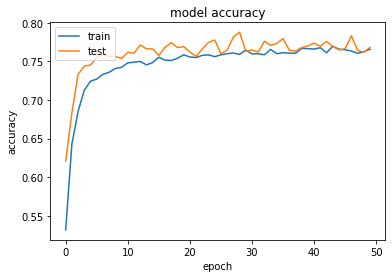

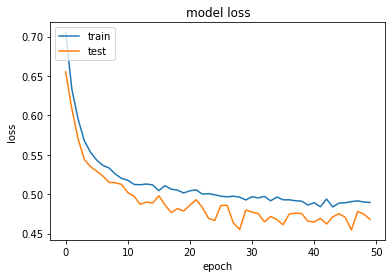

In [0]:
plotMetrics(training_acc, val_acc, training_loss, val_loss)

# Evaluation on Validation Set

In [0]:
if True:
  options['gpu_use'] = True
  device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
  histo_model = models.vgg16_bn(pretrained=True)
  num_in_ftrs = histo_model.classifier[6].in_features
  histo_model.classifier[6] = nn.Linear(num_in_ftrs, 2)

  histo_model = histo_model.to(device)  
  histo_model.load_state_dict(torch.load('{}/{}_model.pt'.format(tmpdir,exp_name)))
  
histo_model.eval()
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(Bar(dataloaders['val'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = histo_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

print("Validation Confusion Matrix:")
print(confusion_matrix)
print("\nValidation Per-class accuracy:")
print(per_class_acc)

confusion_matrix = confusion_matrix.cpu().numpy()
per_class_acc = per_class_acc.cpu().numpy()
pred_class = ['pred_positive(m)', 'pred_negative(b)']
conf_dict = {"Predected\actuall": pred_class, "actuall_positive(m)": confusion_matrix[:,0], "actual_negative(b)": confusion_matrix[:,1], "per_class_acc": per_class_acc}
val_df = pd.DataFrame(conf_dict, columns=['Predected\actuall', 'actuall_positive(m)', 'actual_negative(b)', 'per_class_acc'])
val_df_csv_path = "{}/validation_acc_confusionMatrix.csv".format(tmpdir)
val_df.to_csv(val_df_csv_path)

NameError: ignored

# Evaluation on Training Set

In [0]:
if True:
  options['gpu_use'] = True
  device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
  histo_model = models.vgg16_bn(pretrained=True)
  num_in_ftrs = histo_model.classifier[6].in_features
  histo_model.classifier[6] = nn.Linear(num_in_ftrs, 2)

  histo_model = histo_model.to(device)  
  histo_model.load_state_dict(torch.load('{}/{}_model.pt'.format(tmpdir,exp_name)))
  
histo_model.eval()
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(Bar(dataloaders['train'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = histo_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

print("Validation Confusion Matrix:")
print(confusion_matrix)
print("\nValidation Per-class accuracy:")
print(per_class_acc)

confusion_matrix = confusion_matrix.cpu().numpy()
per_class_acc = per_class_acc.cpu().numpy()
pred_class = ['pred_positive(m)', 'pred_negative(b)']
conf_dict = {"Predected\actuall": pred_class, "actuall_positive(m)": confusion_matrix[:,0], "actual_negative(b)": confusion_matrix[:,1], "per_class_acc": per_class_acc}
val_df = pd.DataFrame(conf_dict, columns=['Predected\actuall', 'actuall_positive(m)', 'actual_negative(b)', 'per_class_acc'])
val_df_csv_path = "{}/Training_acc_confusionMatrix.csv".format(tmpdir)
val_df.to_csv(val_df_csv_path)

26216/26216: [===============================>] - ETA 0.1s
Validation Confusion Matrix:
tensor([[9440., 3668.],
        [3411., 9697.]])

Validation Per-class accuracy:
tensor([0.7202, 0.7398])
